# BloodMNIST Classification Pipeline

## 1. Imports

In [1]:
import torch
import torch.nn as nn
import medmnist

from backend.data_loading import (
    get_data_transforms,
    load_blood_mnist_datasets,
    print_dataset_info,
    create_dataloaders,
    show_image_batch
)
from backend.models.MLP import BaselineMLP
from backend.models.CNN import BaselineCNN
from backend.model_management import (
    record_experiment,
    list_result_runs,
    load_experiment
)
from backend.training import (
    train_model,
    predict_labels,
    compute_confusion_matrix
)

/home/nuno/python_envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

Set the hyperparameters and configuration options for the pipeline.

In [2]:
# configuration parameters
BATCH_SIZE = 128 
DOWNLOAD = True   # download the dataset if not found locally

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Download Dataset: {DOWNLOAD}")

Configuration:
  Batch Size: 128
  Download Dataset: True


## 3. Data Preparation

### 3.1 Get Data Transformations

Define preprocessing transformations to be applied to images.

In [3]:
print("=== Step 1: Preparing data transformations ===")
data_transform = get_data_transforms()
print("Data transformations prepared")

=== Step 1: Preparing data transformations ===
Data transformations prepared


### 3.2 Load BloodMNIST Datasets

Download and load the train, validation, and test splits.

In [4]:
print("=== Step 2: Loading BloodMNIST datasets ===")
train_dataset, val_dataset, test_dataset = load_blood_mnist_datasets(
    data_transform=data_transform,
    download=DOWNLOAD
)
print("Datasets loaded successfully")

=== Step 2: Loading BloodMNIST datasets ===
Datasets loaded successfully


### 3.3 Dataset Information

Information about the dataset splits and classes.

In [5]:
print_dataset_info(train_dataset, val_dataset, test_dataset)


Dataset Information:
Number of training samples: 11959
Number of validation samples: 1712
Number of test samples: 3421
Task: multi-class
Number of channels: 3
Number of classes: 8
Class labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### 3.4 Create DataLoaders

In [6]:
print("=== Step 3: Creating DataLoaders ===")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE
)
print("DataLoaders created successfully")

=== Step 3: Creating DataLoaders ===

Created DataLoaders with batch size 128.
DataLoaders created successfully


## 4. Data Exploration

### 4.1 Visualize Training Data

Display a batch of training images.

=== Step 4: Visualizing training data ===

Labels for the first row of images:
neutrophil, basophil, neutrophil, neutrophil, erythroblast, eosinophil, lymphocyte, eosinophil, platelet, platelet, eosinophil, immature granulocytes(myelocytes, metamyelocytes and promyelocytes), immature granulocytes(myelocytes, metamyelocytes and promyelocytes), lymphocyte, eosinophil, neutrophil


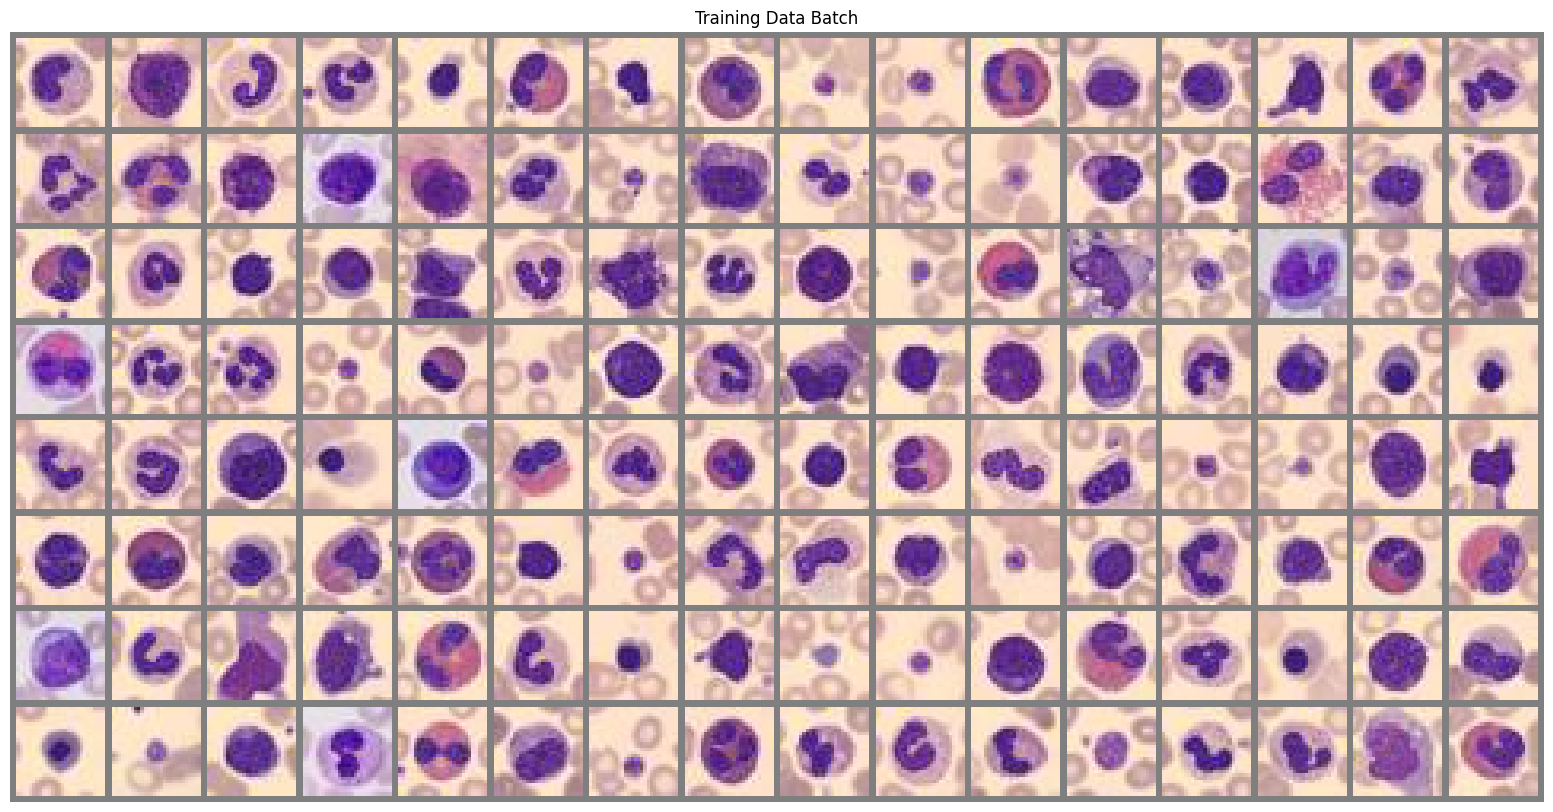

In [7]:
print("=== Step 4: Visualizing training data ===")
show_image_batch(
    data_loader=train_loader,
    dataset=train_dataset,
    title="Training Data Batch"
)

## 5. Baseline MLP Setup

Instantiate baseline classifier.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_architecture = {
    "input_shape": (3, 28, 28),
    "hidden_dims": [512, 256],
    "num_classes": len(train_dataset.info["label"]),
    "dropout": 0.2,
}

#model = build_baseline_mlp(**mlp_architecture).to(device)
model = BaselineMLP(**mlp_architecture).to(device)

current_config = model.get_config()

# Compute class weights to handle class imbalance
dataset_labels = getattr(train_dataset, "labels", None) # get labels from the dataset

labels_tensor = torch.as_tensor(dataset_labels).long().view(-1) # flatten to 1D
num_classes = mlp_architecture["num_classes"] # get number of different classes

class_counts = torch.bincount(labels_tensor, minlength=num_classes).float() # count occurrences of each class
class_weights = labels_tensor.numel() / (num_classes * class_counts.clamp(min=1.0)) # the weight is given by total_samples / (num_classes * class_count)
class_weights = class_weights.to(device=device, dtype=torch.float32) # move to device

criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


print(f"Model on {device}: {model.__class__.__name__}")
print(f"Architecture: {current_config}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Model on cpu: BaselineMLP
Architecture: {'input_shape': (3, 28, 28), 'hidden_dims': [512, 256], 'num_classes': 8, 'dropout': 0.2, 'batch_norm': True}
Class weights: [1.7545482  0.68540806 1.3777649  0.73784554 1.760748   1.5054129
 0.64157724 0.90984476]


## 6. Experiment Tracking

Keep track of saved experiment runs and make reloading straightforward.

In [9]:
existing_runs = list_result_runs(model.__class__.__name__)
print(f"Existing runs for {model.__class__.__name__}: {existing_runs}")

LOAD_RESULTS_DIR = None  # e.g., "../results/BaselineMLP_20251020-153000"

if LOAD_RESULTS_DIR:
    metadata = load_experiment(
        model=model,
        results_dir=LOAD_RESULTS_DIR,
        optimizer=optimizer,
        criterion=criterion,
        map_location=device,
    )
    mlp_architecture = metadata["architecture"]
    current_config = metadata["architecture"]
    if metadata["architecture"] != model.get_config():
        print(
            "Warning: Loaded architecture metadata differs from instantiated model. "
            "Rebuild the model if needed before continuing.",
        )
    print(f"Loaded experiment from {LOAD_RESULTS_DIR}")
    print(f"Loaded architecture: {current_config}")

Existing runs for BaselineMLP: [PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251022-101939'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251022-104123')]


## 7. MLP Training

Run the baseline MLP training loop and report epoch metrics.

In [10]:
EPOCHS = 10
training_history, best_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
 )
model.load_state_dict(best_state)

print("Training summary:")
for epoch_idx, metrics in enumerate(training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in training_history):
    best_epoch, best_metrics = max(
        enumerate(training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

Training summary:
Epoch 1: train_loss=0.7815, train_acc=0.7305, val_loss=0.5752, val_acc=0.7915
Epoch 2: train_loss=0.5112, train_acc=0.8248, val_loss=0.5446, val_acc=0.8143
Epoch 3: train_loss=0.4179, train_acc=0.8557, val_loss=0.5838, val_acc=0.8172
Epoch 4: train_loss=0.3587, train_acc=0.8733, val_loss=0.4291, val_acc=0.8335
Epoch 5: train_loss=0.3099, train_acc=0.8908, val_loss=0.5301, val_acc=0.8388
Epoch 6: train_loss=0.2633, train_acc=0.9074, val_loss=0.6455, val_acc=0.8020
Epoch 7: train_loss=0.2379, train_acc=0.9149, val_loss=0.5110, val_acc=0.8183
Epoch 8: train_loss=0.2125, train_acc=0.9264, val_loss=0.5135, val_acc=0.8283
Epoch 9: train_loss=0.1881, train_acc=0.9308, val_loss=0.4861, val_acc=0.8633
Epoch 10: train_loss=0.1606, train_acc=0.9422, val_loss=0.7703, val_acc=0.8388
Best validation accuracy 0.8633 achieved at epoch 9.


## 8. MLP Evaluation

Evaluate the trained MLP on the test split and persist the results.

In [11]:
test_predictions, test_targets = predict_labels(
    model=model,
    data_loader=test_loader,
    device=device,
 )
test_accuracy = (test_predictions == test_targets).float().mean().item()
confusion_counts = compute_confusion_matrix(
    predictions=test_predictions,
    targets=test_targets,
    num_classes=current_config["num_classes"],
 )
confusion_mat = confusion_counts.to(torch.float32)

tp = confusion_mat.diagonal()
precision = tp / confusion_mat.sum(dim=0).clamp(min=1.0)
recall = tp / confusion_mat.sum(dim=1).clamp(min=1.0)
f1_per_class = torch.zeros_like(tp)
denominator = precision + recall
non_zero = denominator > 0
f1_per_class[non_zero] = (2 * precision[non_zero] * recall[non_zero]) / denominator[non_zero]
f1_macro = f1_per_class.mean().item()

class_labels = [train_dataset.info["label"][str(i)] for i in range(current_config["num_classes"])]
supports = confusion_mat.sum(dim=1)
per_class_metrics = {
    label: {
        "precision": precision[idx].item(),
        "recall": recall[idx].item(),
        "f1": f1_per_class[idx].item(),
        "support": int(supports[idx].item()),
    }
    for idx, label in enumerate(class_labels)
}

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Macro F1 score: {f1_macro:.4f}")
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_counts.numpy())

print("\nPer-class metrics:")
for label, stats in per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

metrics_summary = {
    "accuracy": test_accuracy,
    "f1_macro": f1_macro,
}
extra_metadata = {
    "per_class_metrics": per_class_metrics,
    "class_labels": class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in training_history
    ],
}

mlp_record = record_experiment(
    model=model,
    model_name=model.__class__.__name__,
    architecture=current_config,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics_summary,
    confusion_matrix=confusion_counts,
    extra_metadata=extra_metadata,
    model_type="MLP",
    epochs=EPOCHS,
 )
print(f"\nExperiment artifacts saved to: {mlp_record['path'].resolve()}")

Test accuracy: 0.8462
Macro F1 score: 0.8291
Confusion matrix (rows=true, cols=pred):
[[136   0   1  42  11  54   0   0]
 [  7 564   0  17   1  13  22   0]
 [  4   1 268  14   7   8   7   2]
 [ 11   1   7 410  18 120  12   0]
 [  1   0  14  14 210   3   1   0]
 [  0   0   1  19   3 261   0   0]
 [  0  11  14  46   3  16 576   0]
 [  0   0   0   0   0   0   0 470]]

Per-class metrics:
basophil: precision=85.53%,  recall=55.74%, f1=67.49%,  support=244
eosinophil: precision=97.75%,  recall=90.38%, f1=93.92%,  support=624
erythroblast: precision=87.87%,  recall=86.17%, f1=87.01%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=72.95%,  recall=70.81%, f1=71.87%,  support=579
lymphocyte: precision=83.00%,  recall=86.42%, f1=84.68%,  support=243
monocyte: precision=54.95%,  recall=91.90%, f1=68.77%,  support=284
neutrophil: precision=93.20%,  recall=86.49%, f1=89.72%,  support=666
platelet: precision=99.58%,  recall=100.00%, f1=99.79%,  support=470

## 9. Baseline CNN Setup

Instantiate a convolutional baseline to compare against the MLP results.

In [12]:
cnn_architecture = {
    "input_channels": 3,
    "num_classes": len(train_dataset.info["label"]),
    "conv_channels": [32, 64, 128],
    "linear_dims": [128],
    "dropout": 0.3,
}

#cnn_model = build_baseline_cnn(**cnn_architecture).to(device)
cnn_model = BaselineCNN(**cnn_architecture).to(device)

cnn_config = cnn_model.get_config()

cnn_criterion = nn.CrossEntropyLoss(weight=class_weights)  # weighted loss to counter imbalance
# cnn_criterion = nn.CrossEntropyLoss()  # unweighted loss

cnn_optimizer = torch.optim.AdamW(
    cnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-2,
)
# cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

print(f"Initialized {cnn_model.__class__.__name__} on {device}")
print(f"Architecture: {cnn_config}")

Initialized BaselineCNN on cpu
Architecture: {'input_channels': 3, 'num_classes': 8, 'conv_channels': [32, 64, 128], 'linear_dims': [128], 'dropout': 0.3}


## 10. CNN Training

Train the convolutional network with the same loaders used for the MLP.

In [13]:
CNN_EPOCHS = 15
cnn_training_history, cnn_best_state = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    device=device,
    epochs=CNN_EPOCHS,
 )
cnn_model.load_state_dict(cnn_best_state)

print("CNN training summary:")
for epoch_idx, metrics in enumerate(cnn_training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in cnn_training_history):
    best_epoch, best_metrics = max(
        enumerate(cnn_training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

CNN training summary:
Epoch 1: train_loss=0.8662, train_acc=0.7162, val_loss=0.5327, val_acc=0.8248
Epoch 2: train_loss=0.4409, train_acc=0.8456, val_loss=0.6635, val_acc=0.7512
Epoch 3: train_loss=0.3691, train_acc=0.8722, val_loss=0.3453, val_acc=0.8832
Epoch 4: train_loss=0.3007, train_acc=0.8971, val_loss=0.2720, val_acc=0.9089
Epoch 5: train_loss=0.2584, train_acc=0.9092, val_loss=0.2570, val_acc=0.9077
Epoch 6: train_loss=0.2460, train_acc=0.9152, val_loss=0.2857, val_acc=0.8662
Epoch 7: train_loss=0.1966, train_acc=0.9316, val_loss=0.2327, val_acc=0.9217
Epoch 8: train_loss=0.1887, train_acc=0.9364, val_loss=0.7345, val_acc=0.8195
Epoch 9: train_loss=0.1769, train_acc=0.9368, val_loss=0.2453, val_acc=0.9194
Epoch 10: train_loss=0.1537, train_acc=0.9469, val_loss=0.2446, val_acc=0.8890
Epoch 11: train_loss=0.1361, train_acc=0.9501, val_loss=0.2095, val_acc=0.9357
Epoch 12: train_loss=0.1349, train_acc=0.9517, val_loss=0.3065, val_acc=0.8838
Epoch 13: train_loss=0.1235, train_acc=

## 11. CNN Evaluation

Evaluate the CNN on the test set and store the run artifacts.

In [14]:
cnn_test_predictions, cnn_test_targets = predict_labels(
    model=cnn_model,
    data_loader=test_loader,
    device=device,
 )
cnn_test_accuracy = (cnn_test_predictions == cnn_test_targets).float().mean().item()
cnn_confusion_counts = compute_confusion_matrix(
    predictions=cnn_test_predictions,
    targets=cnn_test_targets,
    num_classes=cnn_config["num_classes"],
 )
cnn_confusion_mat = cnn_confusion_counts.to(torch.float32)

cnn_tp = cnn_confusion_mat.diagonal()
cnn_precision = cnn_tp / cnn_confusion_mat.sum(dim=0).clamp(min=1.0)
cnn_recall = cnn_tp / cnn_confusion_mat.sum(dim=1).clamp(min=1.0)
cnn_f1_per_class = torch.zeros_like(cnn_tp)
cnn_denominator = cnn_precision + cnn_recall
cnn_non_zero = cnn_denominator > 0
cnn_f1_per_class[cnn_non_zero] = (
    2 * cnn_precision[cnn_non_zero] * cnn_recall[cnn_non_zero]
) / cnn_denominator[cnn_non_zero]
cnn_f1_macro = cnn_f1_per_class.mean().item()

cnn_class_labels = [
    train_dataset.info["label"][str(i)] for i in range(cnn_config["num_classes"])
]
cnn_supports = cnn_confusion_mat.sum(dim=1)
cnn_per_class_metrics = {
    label: {
        "precision": cnn_precision[idx].item(),
        "recall": cnn_recall[idx].item(),
        "f1": cnn_f1_per_class[idx].item(),
        "support": int(cnn_supports[idx].item()),
    }
    for idx, label in enumerate(cnn_class_labels)
}

print(f"CNN test accuracy: {cnn_test_accuracy:.4f}")
print(f"CNN macro F1 score: {cnn_f1_macro:.4f}")
print("CNN confusion matrix (rows=true, cols=pred):")
print(cnn_confusion_counts.numpy())

print("\nCNN per-class metrics:")
for label, stats in cnn_per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

cnn_metrics_summary = {
    "accuracy": cnn_test_accuracy,
    "f1_macro": cnn_f1_macro,
}
cnn_extra_metadata = {
    "per_class_metrics": cnn_per_class_metrics,
    "class_labels": cnn_class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in cnn_training_history
    ],
}

cnn_record = record_experiment(
    model=cnn_model,
    model_name=cnn_model.__class__.__name__,
    architecture=cnn_config,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    metrics=cnn_metrics_summary,
    confusion_matrix=cnn_confusion_counts,
    extra_metadata=cnn_extra_metadata,
    model_type="CNN",
    epochs=CNN_EPOCHS,
 )
print(f"\nCNN experiment artifacts saved to: {cnn_record['path'].resolve()}")

CNN test accuracy: 0.9258
CNN macro F1 score: 0.9192
CNN confusion matrix (rows=true, cols=pred):
[[232   1   0   8   0   0   3   0]
 [  2 605   0   1   0   0  16   0]
 [  2   0 287  11   0   0   8   3]
 [ 22   6   2 476   2  18  53   0]
 [ 14   0   8  20 196   2   3   0]
 [  0   0   2  37   4 240   1   0]
 [  0   1   0   4   0   0 661   0]
 [  0   0   0   0   0   0   0 470]]

CNN per-class metrics:
basophil: precision=85.29%,  recall=95.08%, f1=89.92%,  support=244
eosinophil: precision=98.69%,  recall=96.96%, f1=97.82%,  support=624
erythroblast: precision=95.99%,  recall=92.28%, f1=94.10%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=85.46%,  recall=82.21%, f1=83.80%,  support=579
lymphocyte: precision=97.03%,  recall=80.66%, f1=88.09%,  support=243
monocyte: precision=92.31%,  recall=84.51%, f1=88.24%,  support=284
neutrophil: precision=88.72%,  recall=99.25%, f1=93.69%,  support=666
platelet: precision=99.37%,  recall=100.00%, f1=99.6

## Pipeline Summary

Pipeline execution completed! Review the results above and proceed with model training and evaluation.

In [15]:
print("\n=== Pipeline completed ===")
print("\nSummary:")
print("Data loading and preprocessing - DONE")
print("Data visualization - DONE")
print("Baseline MLP training - DONE")
print("Baseline MLP evaluation - DONE")
print("Baseline CNN training - DONE")
print("Baseline CNN evaluation - DONE")


=== Pipeline completed ===

Summary:
Data loading and preprocessing - DONE
Data visualization - DONE
Baseline MLP training - DONE
Baseline MLP evaluation - DONE
Baseline CNN training - DONE
Baseline CNN evaluation - DONE
